# Assignment 1
## Problem 6 - Normalizing Flows

In [4]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pyro.distributions as dist
import torch
from matplotlib import cm
from src.utils.io import load_image, img_to_bw

from src.utils.plotting import init_plot_style, show_grayscale_img
%pylab
%matplotlib inline

init_plot_style()
data_dir='../../data/img/'

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


If necessary, we first have to convert our grayscale icons to a binary image.

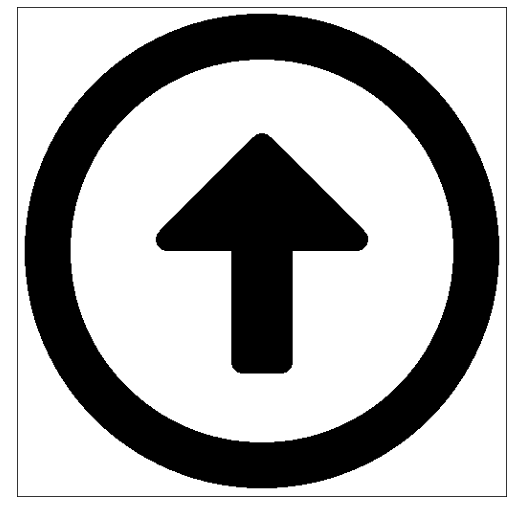

In [5]:
img = img_to_bw(data_dir + 'up.png', data_dir + 'up_bw.png')
show_grayscale_img(img)

Now we can load the binary image and generate samples from it as described in the assignment sheet.

Our image format is 512 x 512.


(0.0, 1.0)

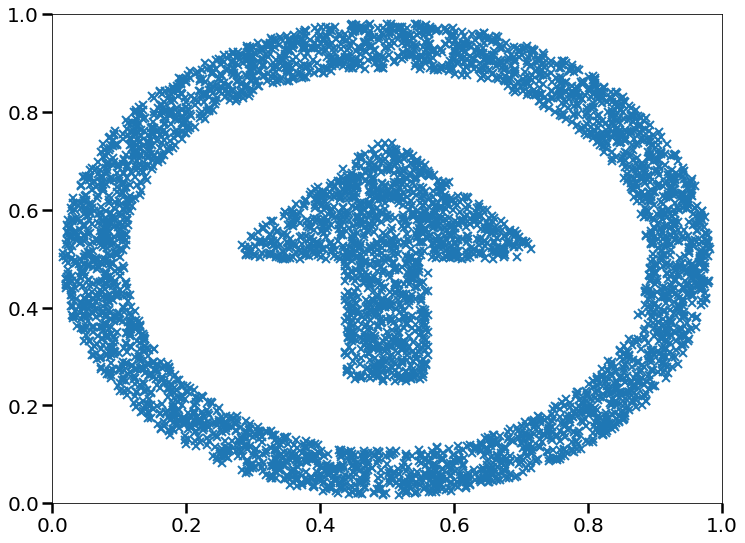

In [7]:
# load image
img = load_image(data_dir + 'up_bw.png')
height, width = img.shape
print(f'Our image format is {width} x {height}.')

# generate training samples
n_samples = 5000 # number of samples to generate
data = np.zeros((n_samples, 2))
rng = np.random.default_rng(seed=0)
i=0
while i < n_samples:
    row = rng.integers(0, height)
    col = rng.integers(0, width)
    if img[row, col] == 0:
        data[i,0] = (col/512)#*2 - 1
        data[i,1] = (row/512)#*2 - 1
        i += 1
        
# plot image with generated samples
#show_grayscale_img(img)
plt.plot(data[:,0], data[:,1], 'x')
plt.xlim([0, width/512])
plt.ylim([0, height/512])




Train your flow here.

In [8]:
# set up the model and train it with n number of steps
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
num_components = 2
bound=2
spline_transform = dist.transforms.spline_coupling(2, count_bins=32, bound=bound)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

# configure optimizier
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)


data_tens = torch.tensor(data, dtype=torch.float)
steps = 1000

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(data_tens).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))
        

step: 0, loss: 4.661159515380859
step: 100, loss: 1.0614781379699707
step: 200, loss: 0.30416738986968994
step: 300, loss: -0.06357930600643158
step: 400, loss: -0.26220184564590454
step: 500, loss: -0.29101935029029846
step: 600, loss: -0.41930386424064636
step: 700, loss: -0.43295472860336304
step: 800, loss: -0.5508103966712952
step: 900, loss: -0.5610801577568054
step: 1000, loss: -0.6012427806854248


Put your learned model to the test: generate and plot some test samples.

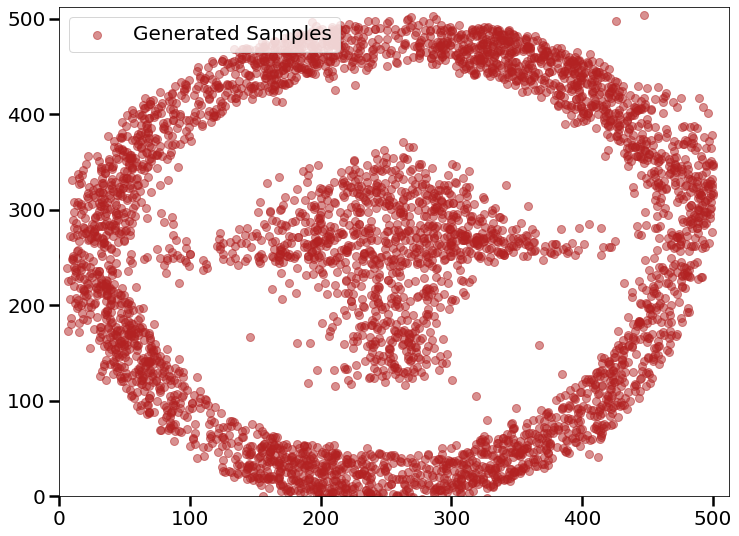

In [13]:
# generate samples from the learned distribution
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy()
plt.close('all')
plt.figure()
#show_grayscale_img(img)
plt.scatter(samples[:,0]*512, samples[:,1]*512, color='firebrick', label='Generated Samples', alpha=0.5)
plt.xlim([0, width])
plt.ylim([0, height])
plt.legend()
#plt.savefig('data/figures/spline_flow_{}_{}_{}_{}.jpg'.format(n_samples,num_components,bound,steps))


We also want to have a look at the log-likelihood of our model!

Text(0.5, 0, 'Y')

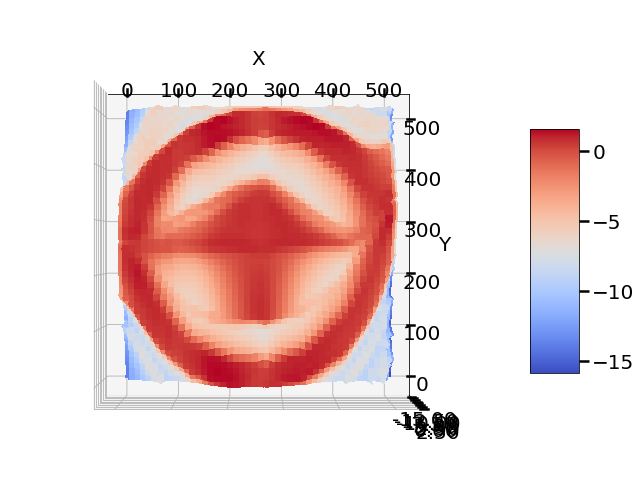

In [14]:

# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)
X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob(coordinates/width).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, log_likelihood, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(azim=-90, elev=90) # bird's eye view

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
#plt.savefig('data/figures/spline_flow_log_{}_{}.jpg'.format(n_samples,num_components))


In [136]:
#6.b autoregressive flow

base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
num_components = 1
bound=2

spline_transform = dist.transforms.spline_autoregressive(2, count_bins=32, bound=bound, order='linear')
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

# configure optimizier
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
data_tens = torch.tensor(data, dtype=torch.float)
steps = 1000

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(data_tens).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 100 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.2283120155334473
step: 100, loss: 0.0687984973192215
step: 200, loss: -0.33170250058174133
step: 300, loss: -0.48211798071861267
step: 400, loss: -0.6031172871589661
step: 500, loss: -0.6798297762870789
step: 600, loss: -0.6693968772888184
step: 700, loss: -0.7112581133842468
step: 800, loss: -0.6669963002204895
step: 900, loss: -0.7403566837310791
step: 1000, loss: -0.7582448124885559


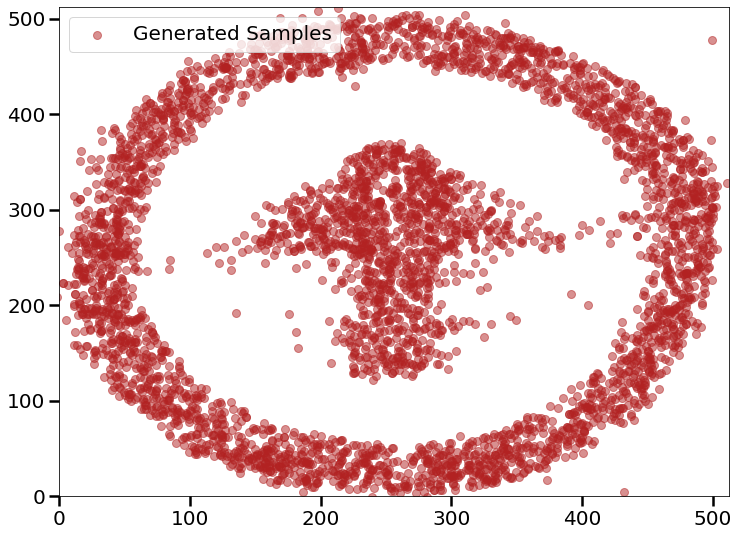

In [137]:
# generate samples from the learned distribution
samples = flow_dist.sample(torch.Size([5000,])).detach().numpy()
plt.close('all')
plt.figure()
#show_grayscale_img(img)
plt.scatter(samples[:,0]*512, samples[:,1]*512, color='firebrick', label='Generated Samples', alpha=0.5)
plt.xlim([0, width])
plt.ylim([0, height])
plt.legend()

#plt.savefig('data/figures/auto_flow_{}_{}_{}_{}.jpg'.format(n_samples,num_components,bound,steps))

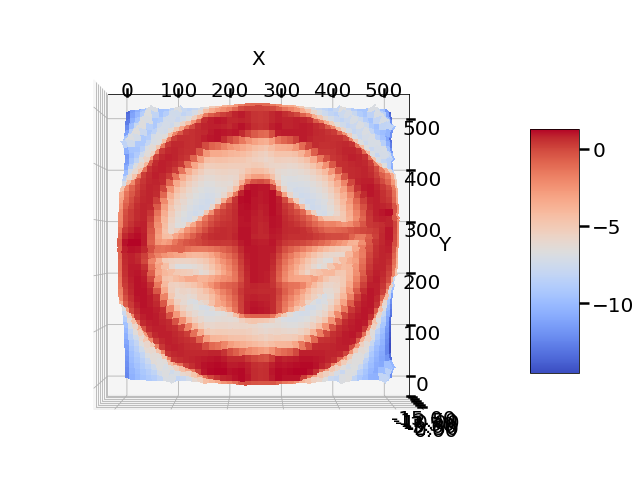

In [138]:
# compute the log-likelihood at a discrete grid
rows = np.arange(0, width)
cols = np.arange(0, height)
X, Y = np.meshgrid(cols, rows)

# flatten the grid points and evaluate their log-liklihoods
coordinates = torch.FloatTensor(np.stack((X,Y), axis=2)).view(-1, 2)
log_likelihood = flow_dist.log_prob(coordinates/width).detach().view(-1,width).numpy()

# finally, let's plot the log-likelihood
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, log_likelihood, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(azim=-90, elev=90) # bird's eye view

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
#plt.savefig('data/figures/auto_flow_log_{}_{}.jpg'.format(n_samples,num_components))